# ROC Analysis 
Module is used to investigate the ability of CGG half sites to predict in vivo binding targets

Code written by NJM and PSR

In [1]:
from KdtoEv2 import psfem
from KdtoEv2 import get_psfem
from KdtoEv2 import make_comparison_frame,add_psfem_info, getScores,get_tpr_fpr_lists, plotROCCurve, getSingleScore, getDoubleScore
from analyze_sig_hits_v2 import pssm, add_pwm_info,make_comparison_frame, get_pssm, get_max_pwm_score
from math import log,e
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from sklearn import metrics
from Bio.Seq import Seq
from Bio.Alphabet.IUPAC import unambiguous_dna, ambiguous_dna
from Bio import SeqUtils
import pandas as pd
import numpy as np
import math
import scipy.stats
import matplotlib.pyplot as plt
import Bio
import os




In [4]:
def removeCannon(df, cutoff, tf = ''):
	df["Score"] = df["Sequence"].apply(lambda x: get_max_pwm_score(x,tf))
	newdf = df[df["Score"]<cutoff]
	return newdf

def foo( sighits, score, lowerCutoff = .00001, upperCutoff = .1, tf = '', testSeq = "CGG"):
	"""This function uses the max number of half sites as a model to differentiate between bound and unbound targets"""
	cf = make_comparison_frame(sighits ,'sig_prom_Gal4_DBD_HarbIG_Final.txt',tf,'DBD')
#	cf = removeCannon(cf, score, tf = '')   
	positives = cf[cf[tf+ " pvalue"]<lowerCutoff]
	negatives = cf[cf[tf+ " pvalue"]>upperCutoff]
	tpr,fpr = get_tpr_fpr_lists(positives,negatives,lambda x: getSpacingMax400AndUp(x, testSeq),False)
	auc = metrics.auc(fpr,tpr)
	return auc, positives, negatives, tpr, fpr

def getSpacingMax400AndUp(inSeq, testSeq):
	"""This function returns the max number of half sites in a intergenic region"""
	seq = Seq(str(inSeq), IUPAC.unambiguous_dna)
	totals = []
	for x in range(0,len(seq)-399):
		inputSeq = seq[x:x+400]
		totals.append(FindConsensusMotif(testSeq,inputSeq))
	if totals:
		return max(totals)
	else:
		return 0 
    
def TF_auc_maxPWM(sig_hits, pwm_score, lowerCutoff = .00001, upperCutoff = .1, tf = ''): #, PSFEM = False):
	"""This function uses max PWM score as a model to differentiate between bound and unbound promoters"""
	cf = make_comparison_frame(sig_hits,'sig_prom_Gal4_DBD_HarbIG_Final.txt',tf,'DBD')
# 	cf = add_pwm_info(cf, tf, pwm_score)
	positives = cf[cf[tf + " pvalue"]<lowerCutoff]
	negatives = cf[cf[tf + " pvalue"]>lowerCutoff]
	tpr,fpr = get_tpr_fpr_lists(positives,negatives,lambda x: get_max_pwm_score(x,str(tf)),False) #Lower better false bc pwms
	auc = metrics.auc(fpr,tpr)
	return auc, positives, negatives, tpr, fpr



def FindConsensusMotif(testseq,seq):
    
    ''' This function takes as input a "consensus motif", which is essentially a consensus sequence,
    but with Ns,Rs,Ys,Ks, and a sequence to scan. It will scan the sequence and return 
    a list of tuples that give the start and stop coordinates of all instances of the 
    consensus motif, on both strands of course.
    
    The consensusMotif variable can be passed to this function a string or a Seq object 
    The input_sequence variable can also be baseed as a string or Seq object'''

    input_sequence = Seq(str(seq),ambiguous_dna)
    consensusMotif = Seq(str(testseq),ambiguous_dna)
    
    #find all instances of consensus motif in forward strand of the sequence
    start_positions_forward = SeqUtils.nt_search(str(input_sequence), str(consensusMotif))[1:]
    
    #find all instances of consensus motif in the reverse strand of the sequence
    
    #first, take the reverse complement of the consensus motif
    rc_consensusMotif = consensusMotif.reverse_complement()
    
    if rc_consensusMotif == consensusMotif: #if consensusMotif is palindromic, don't search reverse strand
        end_positions_reverse = []
    else:
        end_positions_reverse = SeqUtils.nt_search(str(input_sequence), str(rc_consensusMotif))[1:]
    
    #output list of lists giving start and end positions of all motif 
    #instances.  For instance on the forward strand, start < end.  
    #For reverse strand, start > end.  The indices are zero indexed.
    output_list = []
    for startpos in start_positions_forward:
        position_list = [startpos,startpos+len(consensusMotif)-1]
        output_list.append(position_list)
    
    for endpos in end_positions_reverse:
        position_list = [endpos+len(consensusMotif)-1,endpos]
        output_list.append(position_list)
 
    
    return len(output_list)



"""Utility function to plot any ROC curve w up to two lines"""
def plotROC(tpr,fpr, name, auc, name2 = "", tpr2 = 0,fpr2 = 0, auc2 = 0, color = 'r',label = 'ROC', randomline=True):
	"""From analyze sig hits"""
	plt.figure(figsize=(6, 6), dpi=100)
	plt.xlabel("FPR", fontsize=16)
	plt.ylabel("TPR", fontsize=16)
	plt.title("ROC Curve", fontsize=16)
	plt.plot(fpr, tpr, color='darkmagenta', linewidth=2, label= str(name) + ' AUC = ' + str(auc))
	if name2 != "":
		plt.plot(fpr2, tpr2, color='plum', linewidth=2, label= str(name2) + ' AUC = ' + str(auc2))
	x = [0.0, 1.0]
	plt.plot(x, x, linestyle='dashed', color='purple', linewidth=2, label='random')
	plt.xlim(0.0, 1.0)
	plt.ylim(0.0, 1.0)
	plt.tick_params(axis='both', which='major', labelsize=16)
	plt.legend(fontsize=14, loc='best')
	plt.tight_layout()
	plt.savefig("gal4_roc_combined.pdf")

In [5]:
#this function caluclates the standard error for AUC 
#A = AUC
#na = normals: unbound regions, this would be the negatives = TF pvalue >0.00001  
#nn = abnormals: bound regions, this would be the positives = TF pvalue <0.00001
#r is determined from Table 1 in JA Hanely et al., 1983
def calculate_SE_AUC(A,na,nn):
    Q1 = A/(2-A)
    Q2 = ((2*A)*A)/(1+A)
    SE = math.sqrt(((A*(1-A))+((na-1)*(Q1-(A*A)))+((nn-1)*(Q2-A*A)))/(na*nn))
    return SE 
#function that compares the areas under the receiver operating curves 
def cal_zscore(A1,A2,SE1,SE2,r):
    Z_score = (A1 - A2)/(math.sqrt(((SE1*SE1) + (SE2*SE2)) - (2*r*SE1*SE2)))
    return Z_score


In [6]:
auc_nosite, postives_nosite, negatives_n, tpr_nosite, fpr_nosite= foo("sig_prom_Gal4_FL_HarbIG_Final.txt", 13.01, lowerCutoff = .00001, upperCutoff = .1,tf = "Gal4", testSeq = "CGG")

/opt/apps/pybedtools/0.7.7/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
gal4_maxsite, positives_maxsite, negative_maxsite, tpr_maxsite, fpr_maxsite  = TF_auc_maxPWM("sig_prom_Gal4_FL_HarbIG_Final.txt", 13.01, lowerCutoff = .00001, upperCutoff = .1,tf = "Gal4")



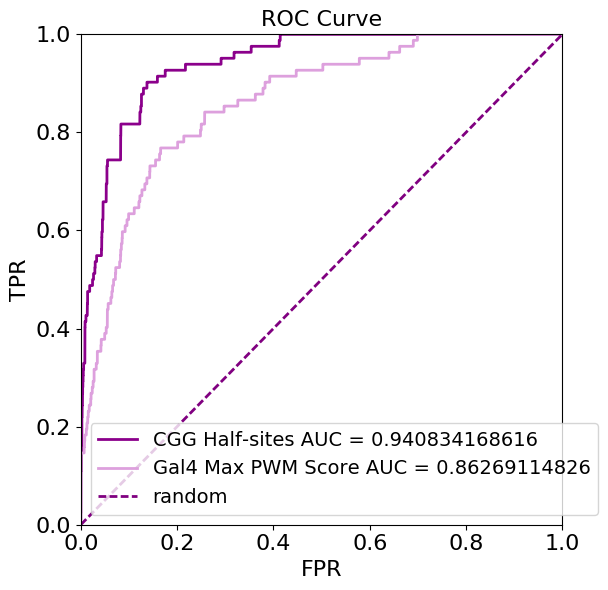

In [11]:
plotROC(tpr_nosite,fpr_nosite, "CGG Half-sites", auc_nosite, "Gal4 Max PWM Score", tpr_maxsite,fpr_maxsite, gal4_maxsite, color = 'r',label = 'ROC',randomline=True)

In [ ]:
plotROC(tpr,fpr, "Gal4p", auc, "canon_removed_optimized", tpr2,fpr2, auc2, color = 'r',label = 'ROC',randomline=True)

In [ ]:
se1 = calculate_SE_AUC(auc_nosite, len(fpr_nosite), len(tpr_nosite))
se2 = calculate_SE_AUC(gal4_maxsite, len(fpr_maxsite), len(tpr_maxsite))

In [ ]:
foo("sig_prom_Gal4_FL_HarbIG_Final.txt", 13.01, lowerCutoff = .00001, upperCutoff = .1,tf = "Gal4", testSeq = "CGG")

In [ ]:
zscore = cal_zscore(auc_nosite,gal4_maxsite,se1,se2,0.86)

In [ ]:
zscore

In [ ]:
scipy.stats.norm.sf(abs(zscore))

# AUC analysis for other zinc clusters

In [14]:
#List of zinc cluster TFs and their PWM cutoff 
list_sig = ['leu3_all_file_2.txt','yrm1_all_file_2.txt', 'yrr1_all_file_2.txt', 'tea1_all_file_2.txt', 'lys14_all_file_2.txt', 'cat8_all_file_2.txt', 'cha4_all_file_2.txt','put3_all_file_2.txt', 'urc2_all_file_2.txt', "hal9_all_file_2.txt", "aro80_all_file_2.txt"]
tf_list = ['Leu3', "Yrm1", "Yrr1", "Tea1", "Lys14", "Cat8","Cha4", "Put3", "Urc2", "Hal9", "Aro80"]
score_cutoff = [9.97, 13.41, 13.12, 14.39, 8.3, 7.31, 9.98, 12.39, 13.7, 9.01, 11.42]

In [15]:
auc_maxpwm = []
positives_maxpwm = []
negatives_maxpwm = []
tpr_maxpwm = []
fpr_maxpwm = []
for m,p, n in zip(list_sig, score_cutoff, tf_list):
    a, b, c, d, e = TF_auc_maxPWM(m,p, tf = n)
    auc_maxpwm.append(a)
    positives_maxpwm.append(b)
    negatives_maxpwm.append(c)
    tpr_maxpwm.append(d)
    fpr_maxpwm.append(e)

In [16]:
auc_maxpwm

[0.89546016922094507,
 0.77981880841233031,
 0.58944652046067136,
 0.71826247123159237,
 0.73220963209714618,
 0.72226398441210682,
 0.70403299031476996,
 0.75760759782360798,
 0.81840893970047102,
 0.83145981377113443,
 0.66905322360068131]

In [27]:
df = pd.DataFrame(list(zip(auc_maxpwm, auc_HS_maxN)), columns = ["maxPWM", "CGG"])
df.to_csv("roc_final_zinccluster.csv", "\t")

In [17]:
auc_HS_maxN = []
positives_HS = []
negatives_HS = []
tpr_HS = []
fpr_HS = []
for m, n, p in zip(list_sig, tf_list, score_cutoff):
    a, b, c, d, e = foo( m, p, lowerCutoff = .00001, upperCutoff = .1, tf = n, testSeq = "CGG")
    auc_HS_maxN.append(a)
    positives_HS.append(b)
    negatives_HS.append(c)
    tpr_HS.append(d)
    fpr_HS.append(e)
    tpr_HS.append(e)

In [33]:
tpr_HS

[[0.0,
  0.009259259259259259,
  0.009259259259259259,
  0.018518518518518517,
  0.027777777777777776,
  0.037037037037037035,
  0.046296296296296294,
  0.046296296296296294,
  0.05555555555555555,
  0.05555555555555555,
  0.05555555555555555,
  0.06481481481481481,
  0.07407407407407407,
  0.08333333333333333,
  0.08333333333333333,
  0.08333333333333333,
  0.09259259259259259,
  0.09259259259259259,
  0.09259259259259259,
  0.10185185185185185,
  0.1111111111111111,
  0.12037037037037036,
  0.12037037037037036,
  0.12037037037037036,
  0.12962962962962962,
  0.12962962962962962,
  0.1388888888888889,
  0.14814814814814814,
  0.1574074074074074,
  0.1574074074074074,
  0.16666666666666666,
  0.16666666666666666,
  0.17592592592592593,
  0.18518518518518517,
  0.18518518518518517,
  0.18518518518518517,
  0.18518518518518517,
  0.19444444444444445,
  0.19444444444444445,
  0.19444444444444445,
  0.2037037037037037,
  0.21296296296296297,
  0.21296296296296297,
  0.21296296296296297,
  

In [19]:
se1_list = []
se2_list = []
for a, b, c, d, e, f in zip(auc_maxpwm, fpr_maxpwm, tpr_maxpwm, auc_HS_maxN, fpr_HS, tpr_HS):
    se1_list.append(calculate_SE_AUC(a, len(b), len(c)))
    se2_list.append(calculate_SE_AUC(d, len(e), len(f)))



In [20]:
auc_r = []
for a, b in zip(auc_maxpwm, auc_HS_maxN):
    auc_r.append((a + b) / 2)

In [31]:
len(fpr_maxpwm)

11

In [35]:
zscore_list = []
for a, b, c, d, e in zip(auc_maxpwm, auc_HS_maxN, se1_list, se2_list, r):
    zscore_list.append(cal_zscore(a, b, c, d, e))
    #print(scores)
    

In [34]:
r = [0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88,0.87, 0.86, 0.88]

In [36]:
pvalue = []
for i in zscore_list:
    pvalue.append(scipy.stats.norm.sf(abs(i)))




In [37]:
pvalue

[1.5158614536376258e-10,
 0.0,
 0.0,
 0.0,
 2.4341113069791276e-85,
 0.0,
 4.475276836581732e-27,
 1.0605997790345927e-13,
 1.8615886307888555e-07,
 0.0,
 1.555436291948494e-101]

In [39]:
zscore_list

[-6.2971477447156845,
 -39.843403373527536,
 -81.996791773788701,
 -45.729778640113729,
 19.541548965289387,
 -65.815991713754471,
 -10.711900174097252,
 -7.3409267054916532,
 -5.0825925863395787,
 -48.720225544682236,
 -21.360555889433002]

In [40]:
df_stats = pd.DataFrame(list(zip(zscore_list, pvalue)), columns = ["zscore", "pvalue"])
df_stats.to_csv("roc_final_zinccluster_stats.csv", "\t")